In [1]:
import datetime
from typing_extensions import TypedDict
from typing import List
import json
import os.path

class PortfolioItem(TypedDict):
    ticker: str
    friendlyName: str
    amount: int
Portfolio = List[PortfolioItem]

def loadPortfolio() -> Portfolio:
    custom = 'portfolio.json'
    sample = 'portfolioSample.json'
    useSample = False
    if not os.path.isfile(custom):
        print("Using sample data.\nPlease create a portfolio.json to use custom input.")
        useSample = True
    with open(sample if useSample else custom, 'r') as infile:
        return json.load(infile)

portfolio = loadPortfolio()
useDataOverYears = 5 # 1y,2y,5y,10y
endDate = datetime.date.today() # only influences parsing atm, not collection

In [2]:
import json
import yfinance as yf
import os.path
import pandas as pd

def getDataFileName(name: str) -> str:
    return f'data/{name}.json'

def convertDataFrameToJson(df: pd.DataFrame) -> any:
    return json.loads(df.to_json())

def writeJsonToFile(name: str, payload: any) -> None:
    filename = getDataFileName(name)
    with open(filename, 'w') as outfile:
        json.dump(payload, outfile)

    print(f"{filename} saved!")
    
def getYFDataFrame(ticker: str, years: int) -> pd.DataFrame:
    dataframe = yf.download(
        ticker, 
        period=str(years)+'y',
        prepost=True,
        interval="1d" # none of the larger intervals seem to be consistent
    )
    
    return dataframe

def downloadPortfolio(portfolio: Portfolio, years: int, partial=True) -> None:
    for stock in portfolio:
        ticker = stock["ticker"]
        if not os.path.isfile(getDataFileName(ticker)) or not partial:
            print(f"Retreiving {ticker} information...")
            writeJsonToFile(
                ticker,
                convertDataFrameToJson(
                    getYFDataFrame(ticker, years)
                )
            )
        else:
            print(f"{ticker} already exists. Skipping download")

    
downloadPortfolio(portfolio, useDataOverYears)

NDQ.AX already exists. Skipping download
OTGLF already exists. Skipping download
DRUG.AX already exists. Skipping download
ENZL already exists. Skipping download


In [3]:
import numpy as np
import pandas as pd
import json
import datetime
import functools

def getPortfolioWeight(ticker: str) -> float:
    portfolioSum = functools.reduce(lambda acc, curr: acc + curr['amount'], portfolio, 0)
    tickerVal = 0
    for stock in portfolio:
        if stock['ticker'] == ticker:
            tickerVal = stock['amount']
            
    return tickerVal/portfolioSum
    
class PortfolioInfo(TypedDict):
    ticker: str
    name: str
    fromDate: any
    toDate: any
    changePerAnnum: float
        
def percentOfDifference(x):
    current = x.iloc[-1]
    previous = x.iloc[0]
    print(f'previous: {previous} ::: current {current}')
    
    return (current - previous)
    
def parseStockDataFrame(df: pd.DataFrame, portfolioEntry: PortfolioItem) -> PortfolioInfo:    
    # initialise fundamental dates
    minDate = df.index[0]
    maxDate = endDate - datetime.timedelta(weeks=useDataOverYears*52)
    fromDate = maxDate if maxDate >= minDate else minDate
    
    relevantDf = df[df.index > fromDate.isoformat()]
    
    closes = relevantDf["Adj Close"]
    differences = []
    # this is pretty inefficient for pandas, I'm aware
    # but I don't know how else we can get a rolling difference
    for i, day in enumerate(closes):
        previous = closes[i-1]
        current = closes[i]
        if i == 0:
            differences.append(0)
        elif not pd.isna(previous) and not pd.isna(current):
            diff = (current - previous) / previous
            differences.append(diff)
        else:
            raise Exception('NAN in data')
        
    changePerAnnum = np.mean(differences) * 253 # about ~253 working days in a year
    
    
    return {
        'ticker': portfolioEntry['ticker'],
        'name': portfolioEntry['friendlyName'],
        'weight': getPortfolioWeight(portfolioEntry['ticker']),
        'fromDate': fromDate,
        'toDate': endDate,
        'changePerAnnum': changePerAnnum
    }

portfolioMeans = []
for entry in portfolio:
    portfolioMeans.append(
        parseStockDataFrame(
            pd.read_json(
                getDataFileName(entry['ticker'])
            ),
            entry
        )
    )
    
    
portfolioDf = pd.DataFrame(portfolioMeans)
portfolioDf['weightedReturnPerAnnum'] = portfolioDf['weight'] * portfolioDf['changePerAnnum']
portfolioDf



,ticker,name,weight,fromDate,toDate,changePerAnnum,weightedReturnPerAnnum
0,NDQ.AX,NASDAQ,0.500000,2015-09-02,2020-08-26,0.211170,0.105585
1,OTGLF,CD Projekt Red,0.250000,2017-04-12,2020-08-26,0.699770,0.174943
2,DRUG.AX,DRUG ETF,0.166667,2016-08-04,2020-08-26,0.100578,0.016763
3,ENZL,New Zealand ETF,0.083333,2015-09-02,2020-08-26,0.184163,0.015347


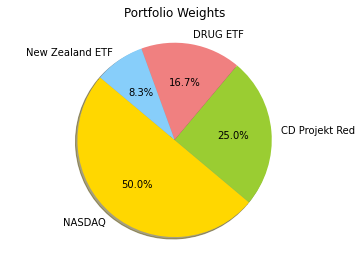

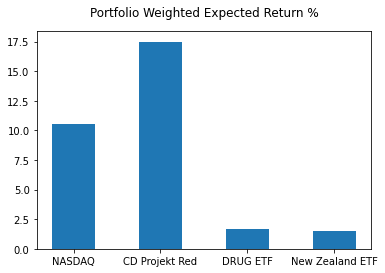

Total Expected % Return is 31.26374780434001


In [4]:
import matplotlib.pyplot as plt

# Data to plot
labels = portfolioDf['name']
weights = portfolioDf['weight']
weightedChange = portfolioDf['weightedReturnPerAnnum']
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Weights
plt.pie(
    weights, 
    labels=labels, 
    colors=colors,
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=140
)
plt.axis('equal')
plt.title("Portfolio Weights", pad=15)

plt.show()

# Change By Weight
plt.bar(
    labels, 
    weightedChange * 100,
    0.5
)
plt.title("Portfolio Weighted Expected Return %", pad=15)

plt.show()
print(f"Total Expected % Return is {weightedChange.sum()*100}")